# *Etapa 4: Processamento dos dados*

Neste notebook, realizamos a junção das principais bases. São elas:

- ``df_offers``: informações das ofertas
- ``df_profile``: informações dos clientes
- ``df_client_transactions``: informações das transações
- ``transactions_received``: informações dos eventos de ofertas recebidas
- ``transactions_viewed``: informações dos eventos de ofertas visualizadas
- ``transactions_completed``: informações dos eventos de ofertas concluidas

Ao término do processamento, devemos ter as seguintes variáveis:

## mastertable
* ``client_id``: código de identificação do cliente
* ``offer_id``:  id da oferta
* ``time_received``: tempo desde o começo do teste em dias (t=0)
* ``qtd_offer_received``: quantidade de ofertas recebidas
* ``time_viewed``: tempo desde o começo do teste em dias (t=0)
* ``qtd_offer_viewed``: quantidade de ofertas visualizadas
* ``time_completed``: tempo desde o começo do teste em dias (t=0)
* ``qtd_offer_completed``: quantidade de ofertas completadas
* ``sum_reward``: desconto
* ``registered_on``: data de criação da conta
* ``registered_duration_days``: tempo de relacionamento em dias
* ``registered_duration_month``: tempo de relacionamento em meses
* ``registered_duration_years``: tempo de relacionamento em anos
* ``gender``: gênero do cliente
* ``gender_M``: variável dummy para indicar o gênero masculino 'M'
* ``gender_F``: variável dummy para indicar o gênero feminino 'F'
* ``gender_O``: variável dummy para indicar o gênero outros 'O'
* ``gender_U``: variável dummy para indicar o gênero desconhecido 'U'
* ``age``: idade do cliente na criação da conta
* ``age_group``: grupo de idades de 10 em 10 anos
* ``age_group_index``: identificador para o grupo de idade
* ``credit_card_limit``: limite do cartão registrado
* ``category_limite``: indicador de renda do cliente (1=renda menor, 5=renda maior)
* ``offer_type``: o tipo da oferta (BOGO, discount, informational)
* ``offer_min_value``: valor mínimo para ativação da oferta
* ``offer_discount_value``: valor do desconto da oferta
* ``offer_duration``: duração da oferta
* ``channel_mobile``: variável dummy para indicar a veiculação da oferta em 'mobile'
* ``channel_email``: variável dummy para indicar a veiculação da oferta em 'email'
* ``channel_social``: variável dummy para indicar a veiculação da oferta em 'social'
* ``channel_web``: variável dummy para indicar a veiculação da oferta em 'web'
* ``offer_type_index``: um código para o tipo de oferta
* ``time_transaction``: tempo desde o começo do teste em dias (t=0)
* ``qtd_transaction``: quantidade de transações
* ``total_amount``: valor da transação
* ``avg_amount``: valor médio do valor da transação

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('PySparkTest').getOrCreate()

from IPython.display import display, HTML
display(HTML("<style>.jp-Cell-outputArea { text-align: center; }</style>"))

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/10 15:55:42 WARN Utils: Your hostname, N0L144853, resolves to a loopback address: 127.0.1.1; using 192.168.3.112 instead (on interface wlp0s20f3)
25/08/10 15:55:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/10 15:55:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/08/10 15:55:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/08/10 15:55:43 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/08/10 15:55:43 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/08/10 15:55:43 WARN Utils

In [2]:
import plotly.express as px
from pyspark.sql import types as T
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Read Files

In [3]:
path_output_mastertable = '../data/trusted/mastertable'

path_table_offers = "../data/trusted/offers"
path_table_profile = "../data/trusted/profile"

path_client_transactions = "../data/trusted/client_transactions"
path_transactions_received = "../data/trusted/transactions_received"
path_transactions_viewed = "../data/trusted/transactions_viewed"
path_transactions_completed = "../data/trusted/transactions_completed"


df_offers = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_table_offers)
df_profile = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_table_profile)

df_client_transactions = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_client_transactions)
transactions_received = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_transactions_received)
transactions_viewed = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_transactions_viewed)
transactions_completed = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_transactions_completed)

# Data Merge

##### Juntando tabela de eventos

In [4]:
df = transactions_received.join(transactions_viewed, on=['client_id','offer_id'], how='left')\
                          .join(transactions_completed, on=['client_id','offer_id'], how='left')\
                          .fillna({'qtd_offer_completed': 0, 'qtd_offer_viewed': 0, 'sum_reward': 0})\
                          .withColumn("time_viewed", F.coalesce(F.col("time_viewed"), F.array().cast(T.ArrayType(T.DoubleType()))))\
                          .withColumn("time_completed", F.coalesce(F.col("time_completed"), F.array().cast(T.ArrayType(T.DoubleType()))))\
                          .orderBy('client_id','offer_id')

df.show(5, truncate=False)

+--------------------------------+--------------------------------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+
|client_id                       |offer_id                        |time_received|qtd_offer_received|time_viewed|qtd_offer_viewed|time_completed|qtd_offer_completed|sum_reward|
+--------------------------------+--------------------------------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+
|0009655768c64bdeb2e877511632db8f|2906b810c7d4411798c6938adc9daaa5|[24.0]       |1                 |[]         |0               |[24.0]        |1                  |2.0       |
|0009655768c64bdeb2e877511632db8f|3f207df678b143eea3cee63160fa8bed|[14.0]       |1                 |[15.5]     |1               |[]            |0                  |0.0       |
|0009655768c64bdeb2e877511632db8f|5a8bc65990b245e5a138643cd4eb9837|[7.0]        |1                 |[8.0]      |1       

In [5]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+
|client_id|offer_id|time_received|qtd_offer_received|time_viewed|qtd_offer_viewed|time_completed|qtd_offer_completed|sum_reward|
+---------+--------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+
|        0|       0|            0|                 0|          0|               0|             0|                  0|         0|
+---------+--------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+



In [6]:
df.groupBy("qtd_offer_completed").count().show()

+-------------------+-----+
|qtd_offer_completed|count|
+-------------------+-----+
|                  0|34292|
|                  1|24793|
|                  3|  342|
|                  2| 3842|
|                  4|   19|
+-------------------+-----+



##### Juntando com dados das ofertas, dos clientes e transações dos clientes

In [7]:
df_merge = df.join(df_profile, on="client_id", how="left")\
             .join(df_offers, on="offer_id", how="left")\
             .join(df_client_transactions, on="client_id", how="left")\
             .fillna({'qtd_transaction': 0, 'total_amount': 0, 'avg_amount': 0})\
             .withColumn("time_transaction", F.coalesce(F.col("time_transaction"), F.array().cast(T.ArrayType(T.DoubleType()))))

df_merge.show(5, truncate=False)

25/08/10 15:55:57 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------------------+--------------------------------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+-------------+------------------------+-------------------------+-------------------------+------+--------+--------+--------+--------+---+---------+---------------+-----------------+---------------+-------------+---------------+--------------------+--------------+--------------+-------------+--------------+-----------+----------------+-------------------------------------------------+---------------+------------+----------+
|client_id                       |offer_id                        |time_received|qtd_offer_received|time_viewed|qtd_offer_viewed|time_completed|qtd_offer_completed|sum_reward|registered_on|registered_duration_days|registered_duration_month|registered_duration_years|gender|gender_M|gender_F|gender_O|gender_U|age|age_group|age_group_index|credit_card_limit|category_limite|offer_type   |offer_min_

In [8]:
df_merge.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_merge.columns]).show()

+---------+--------+-------------+------------------+-----------+----------------+--------------+-------------------+----------+-------------+------------------------+-------------------------+-------------------------+------+--------+--------+--------+--------+---+---------+---------------+-----------------+---------------+----------+---------------+--------------------+--------------+--------------+-------------+--------------+-----------+----------------+----------------+---------------+------------+----------+
|client_id|offer_id|time_received|qtd_offer_received|time_viewed|qtd_offer_viewed|time_completed|qtd_offer_completed|sum_reward|registered_on|registered_duration_days|registered_duration_month|registered_duration_years|gender|gender_M|gender_F|gender_O|gender_U|age|age_group|age_group_index|credit_card_limit|category_limite|offer_type|offer_min_value|offer_discount_value|offer_duration|channel_mobile|channel_email|channel_social|channel_web|offer_type_index|time_transaction|q

In [21]:
df_merge.write.format("parquet").mode("overwrite").save(path_output_mastertable)

# Analysis

In [9]:
df_merge_analysis = df_merge.select("client_id", 'offer_id', 'qtd_offer_received', 'qtd_offer_completed', 'offer_type', 'gender', 'age', 'age_group', 'age_group_index', 'category_limite')  
df_merge_analysis.show(5, truncate=False)

+--------------------------------+--------------------------------+------------------+-------------------+-------------+------+---+---------+---------------+---------------+
|client_id                       |offer_id                        |qtd_offer_received|qtd_offer_completed|offer_type   |gender|age|age_group|age_group_index|category_limite|
+--------------------------------+--------------------------------+------------------+-------------------+-------------+------+---+---------+---------------+---------------+
|0009655768c64bdeb2e877511632db8f|2906b810c7d4411798c6938adc9daaa5|1                 |1                  |discount     |M     |33 |30-39    |2              |3              |
|0009655768c64bdeb2e877511632db8f|3f207df678b143eea3cee63160fa8bed|1                 |0                  |informational|M     |33 |30-39    |2              |3              |
|0009655768c64bdeb2e877511632db8f|5a8bc65990b245e5a138643cd4eb9837|1                 |0                  |informational|M     |33 

##### Analisando Taxa de Conversao de ofertas por Faixa Etaria e Tipo de Oferta

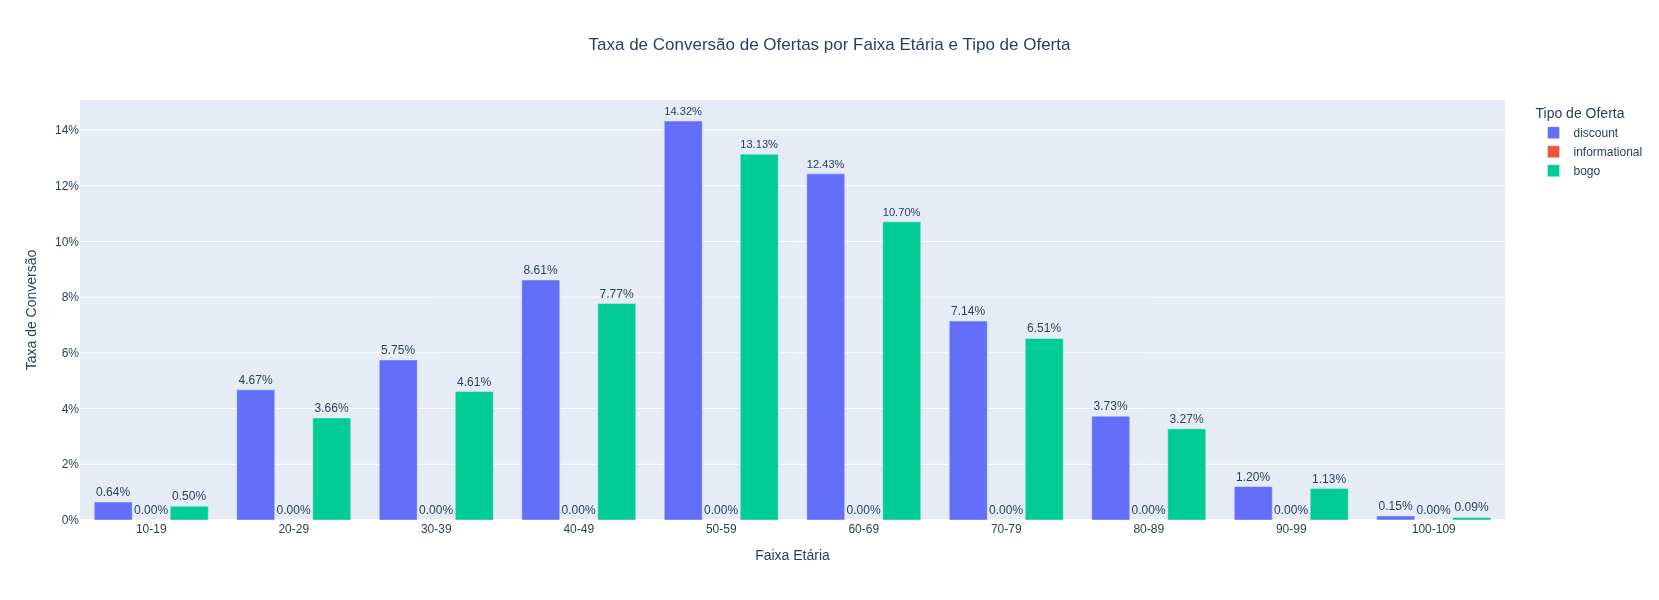

In [10]:
fig = px.bar(
    df_merge_analysis.groupBy('age_group', 'age_group_index', 'offer_type').agg(F.sum('qtd_offer_completed').alias('qtd_offer_completed'))\
                     .join(df_merge_analysis.groupBy('offer_type').agg(F.sum('qtd_offer_received').alias('total_ofertas')), on='offer_type', how='inner')\
                     .withColumn('rate_convertion', F.col('qtd_offer_completed')/F.col('total_ofertas'))\
                     .orderBy('age_group_index').toPandas(),
    x="age_group",
    y="rate_convertion",
    color="offer_type",
    barmode="group",
    text="rate_convertion",
    labels={
        "age_group": "Faixa Etária",
        "rate_convertion": "Taxa de Conversão",
        "offer_type": "Tipo de Oferta"
    },
    title="Taxa de Conversão de Ofertas por Faixa Etária e Tipo de Oferta"
)
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(yaxis_tickformat=".0%")

fig.update_layout(
    title=dict(x=0.5, xanchor="center"),
    height=600,
    width=1600
)

fig.show()

##### Analisando Ofertas completadaspor Tipo de Oferta

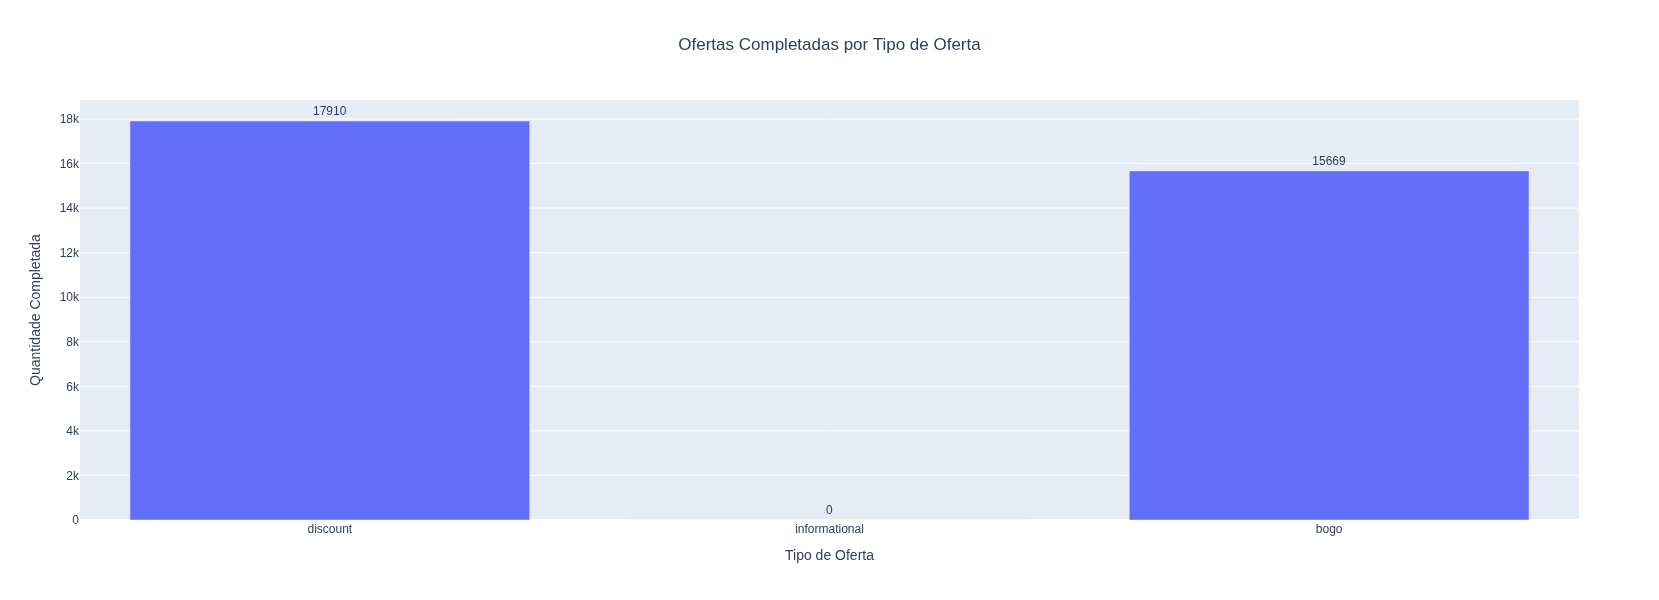

In [11]:
fig = px.bar(
    df_merge_analysis.groupBy('offer_type').agg(F.sum('qtd_offer_completed').alias('qtd_offer_completed')).toPandas(),
    x="offer_type",
    y="qtd_offer_completed",
    text="qtd_offer_completed",
    title="Ofertas Completadas por Tipo de Oferta",
    labels={"offer_type": "Tipo de Oferta", "qtd_offer_completed": "Quantidade Completada"},
)

fig.update_traces(textposition='outside')

fig.update_layout(
    title=dict(x=0.5, xanchor="center"),
    height=600,
    width=800
)
fig.show()

##### Analisando Ofertas completadas por Faixa Etaroa e Renda

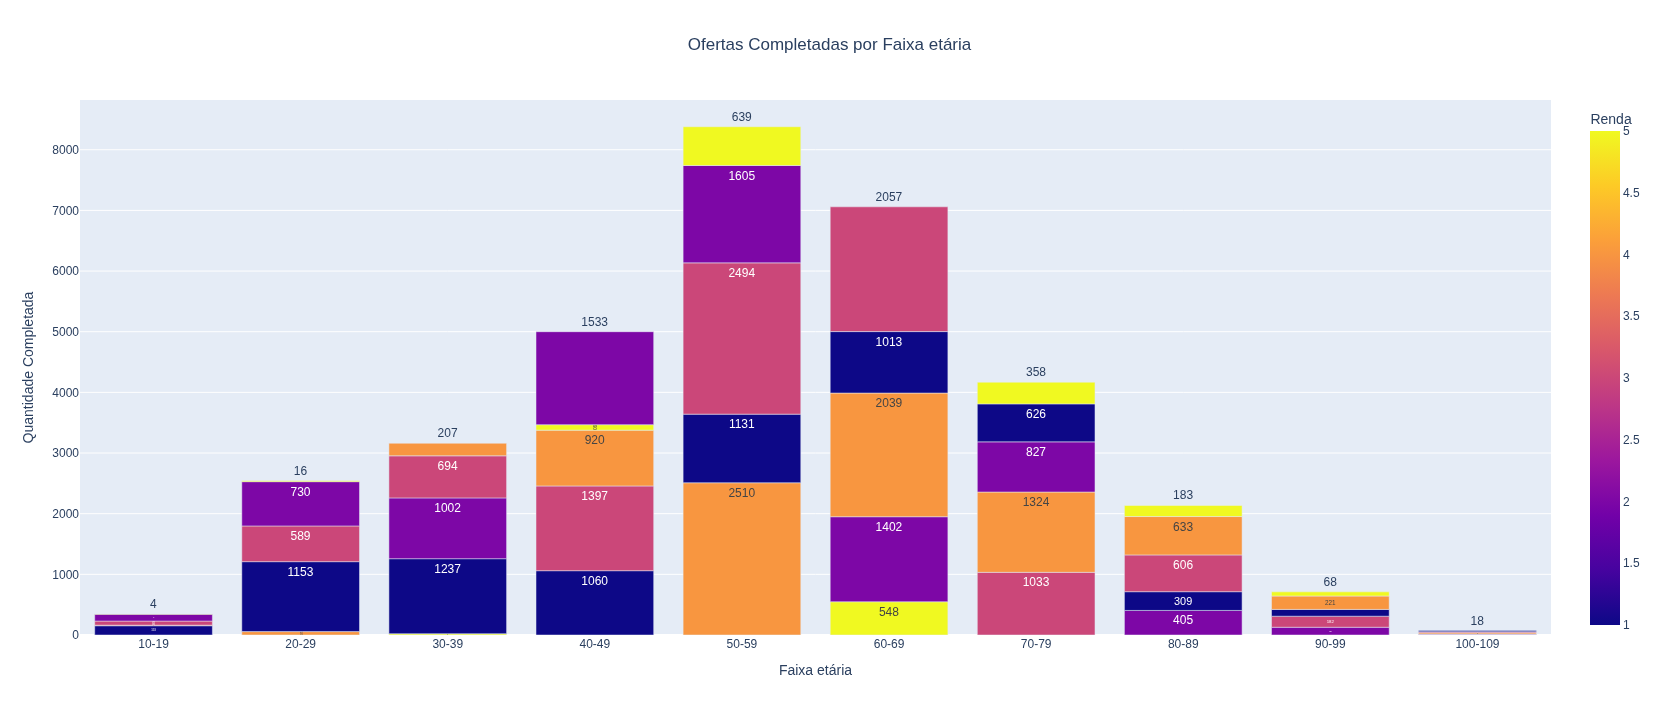

In [12]:
fig = px.bar(
    df_merge_analysis.groupBy('age_group', 'age_group_index', 'category_limite').agg(F.sum('qtd_offer_completed').alias('qtd_offer_completed'))\
                     .orderBy('age_group_index').toPandas(),
    x="age_group",
    y="qtd_offer_completed",
    color="category_limite",
    text="qtd_offer_completed",
    title="Ofertas Completadas por Faixa etária",
    labels={"age_group": "Faixa etária", "qtd_offer_completed": "Quantidade Completada", 'category_limite': "Renda"},
)

fig.update_traces(textposition='outside')

fig.update_layout(
    title=dict(x=0.5, xanchor="center"),
    height=700,
    width=1800
)
fig.show()


##### Analisando Ofertas completadas por Genero

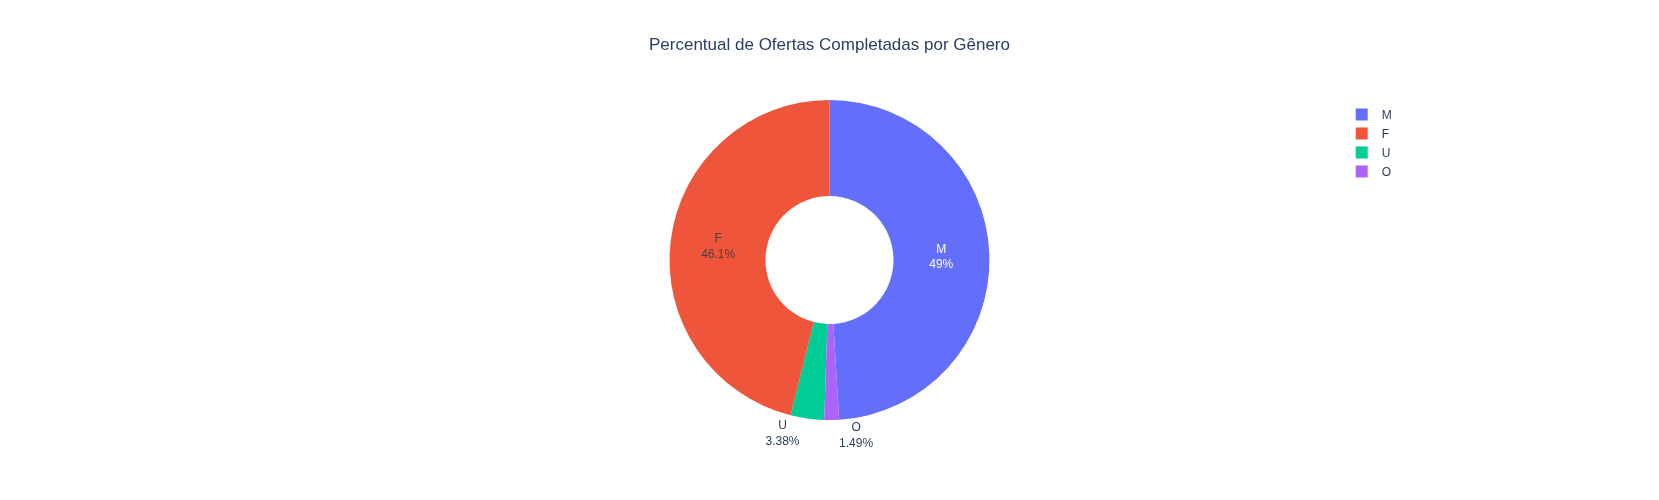

In [13]:
fig = px.pie(
    df_merge_analysis.groupBy('gender').agg(F.sum('qtd_offer_completed').alias('qtd_offer_completed')).orderBy('gender').toPandas(),
    names="gender",
    values="qtd_offer_completed",
    title="Percentual de Ofertas Completadas por Gênero",
    hole=0.4  
)

fig.update_traces(textinfo='percent+label')

fig.update_layout(
    title=dict(x=0.5, xanchor="center"),
    height=500,
    width=1500
)
fig.show()

##### Analisando Ofertas completadas por Renda

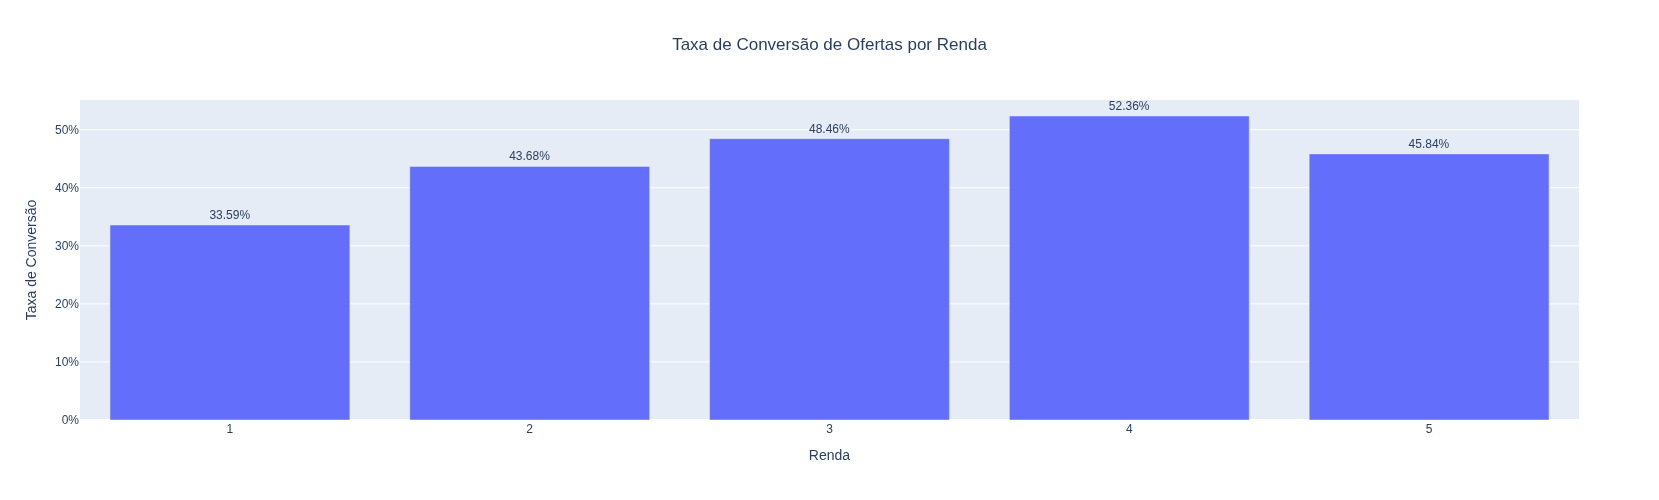

In [14]:
fig = px.bar(
    df_merge_analysis.groupBy('category_limite').agg(F.sum('qtd_offer_completed').alias('qtd_offer_completed'), 
                                                     F.sum('qtd_offer_received').alias('total_ofertas'))\
        .withColumn('rate_convertion', F.col('qtd_offer_completed')/F.col('total_ofertas'))\
        .orderBy('category_limite').toPandas(),
    x="category_limite",
    y="rate_convertion",
    text="rate_convertion",
    title="Taxa de Conversão de Ofertas por Renda",
    labels={"category_limite": "Renda", "rate_convertion": "Taxa de Conversão"},
)

fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')

fig.update_layout(
    title=dict(x=0.5, xanchor="center"),
    height=500,
    width=1500,
    yaxis_tickformat=".0%"
)
fig.show()

### Considerações

 - Descontos são mais procurados que ofertas rápidas
    - Descontos são eficazes em clientes entre 40 e 60 anos
 - Ofertas informativas não tiveram nenhuma conclusão
    - Os dados nos mostram que não vale a pena manter do jeito que está
 - Clientes mais velhos e mais ricos procuram mais ofertas que pessoas mais novas
 - Sugestão: Melhorar Ofertas para pessoas mais Jovens e de Baixa Renda
 - Interessante: Todos os Grupos de Idades têm representação de renda.
 - Features que fazem total mudança: Faixa Etária, Renda, Tipo da Oferta


# Modeling

In [15]:
aux = df_merge.select("client_id", 'offer_id', "qtd_offer_received", 'qtd_offer_completed', 'offer_type')\
              .groupBy("client_id", 'offer_type')\
              .agg(F.sum("qtd_offer_received").alias("offer_type_count"))

aux.show(5, truncate=False)

+--------------------------------+-------------+----------------+
|client_id                       |offer_type   |offer_type_count|
+--------------------------------+-------------+----------------+
|00bc983061d3471e8c8e74d31b7c8b6f|discount     |2               |
|0222d267445f4f078bc325224e471766|bogo         |2               |
|03118ab70a404fada1a433cd6abaa491|bogo         |1               |
|033d0a511a5c452ea2be37a23f8c6dcb|informational|2               |
|072731be403a472883bed6c38a8e7aa8|bogo         |1               |
+--------------------------------+-------------+----------------+
only showing top 5 rows


In [16]:
df_freq_bayes = df_merge.select("client_id", 'offer_id', 'qtd_offer_completed', 'offer_type')\
                        .join(aux, on=['client_id', 'offer_type'], how='left')\
                        .select("client_id", "offer_type", "offer_id", "qtd_offer_completed", "offer_type_count")\
                        .withColumn("freq_bayes", F.when(F.col("offer_type_count")!=0, F.col("qtd_offer_completed")/F.col("offer_type_count")).otherwise(0))\
                        .orderBy("client_id", 'offer_id')
df_freq_bayes.show(truncate=False)

+--------------------------------+-------------+--------------------------------+-------------------+----------------+------------------+
|client_id                       |offer_type   |offer_id                        |qtd_offer_completed|offer_type_count|freq_bayes        |
+--------------------------------+-------------+--------------------------------+-------------------+----------------+------------------+
|0009655768c64bdeb2e877511632db8f|discount     |2906b810c7d4411798c6938adc9daaa5|1                  |2               |0.5               |
|0009655768c64bdeb2e877511632db8f|informational|3f207df678b143eea3cee63160fa8bed|0                  |2               |0.0               |
|0009655768c64bdeb2e877511632db8f|informational|5a8bc65990b245e5a138643cd4eb9837|0                  |2               |0.0               |
|0009655768c64bdeb2e877511632db8f|bogo         |f19421c1d4aa40978ebb69ca19b0e20d|1                  |1               |1.0               |
|0009655768c64bdeb2e877511632db8f|

In [17]:
df_freq_bayes.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_freq_bayes.columns]).show()

+---------+----------+--------+-------------------+----------------+----------+
|client_id|offer_type|offer_id|qtd_offer_completed|offer_type_count|freq_bayes|
+---------+----------+--------+-------------------+----------------+----------+
|        0|         0|       0|                  0|               0|         0|
+---------+----------+--------+-------------------+----------------+----------+



In [18]:
# df_freq_bayes.write.format("parquet").mode("overwrite").save('../data/trusted/freq_bayes')

In [19]:
df_features = df_merge.select('client_id', 'offer_id', 'offer_type_index', 'qtd_offer_received', 'qtd_offer_viewed', 'qtd_offer_completed', 'sum_reward', 
                              'registered_duration_month', 'registered_duration_years', 'gender_M', 'gender_F', 'gender_O','gender_U', 'age_group_index', 
                              'credit_card_limit', 'category_limite', 'offer_min_value', 'offer_discount_value', 'offer_duration', 'qtd_transaction', 
                              'total_amount', 'avg_amount')\
                        .withColumn('target', F.when(F.col('qtd_offer_completed')>0, 1).otherwise(0))\
                        .drop('qtd_offer_completed')
df_features.show(5, truncate=False)

+--------------------------------+--------------------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------+----------+------+
|client_id                       |offer_id                        |offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|total_amount|avg_amount|target|
+--------------------------------+--------------------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------

In [20]:
df_features.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|28996|
|     0|34292|
+------+-----+



# RF PySpark

In [209]:
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [315]:
features = ['offer_type_index',  'offer_min_value', 'offer_discount_value', 'offer_duration', 'gender_M', 
            'gender_F', 'gender_O', 'gender_U', 'age_group_index','category_limite', 'registered_duration_month',
            'registered_duration_years', 'qtd_transaction', 'total_amount', 'avg_amount']

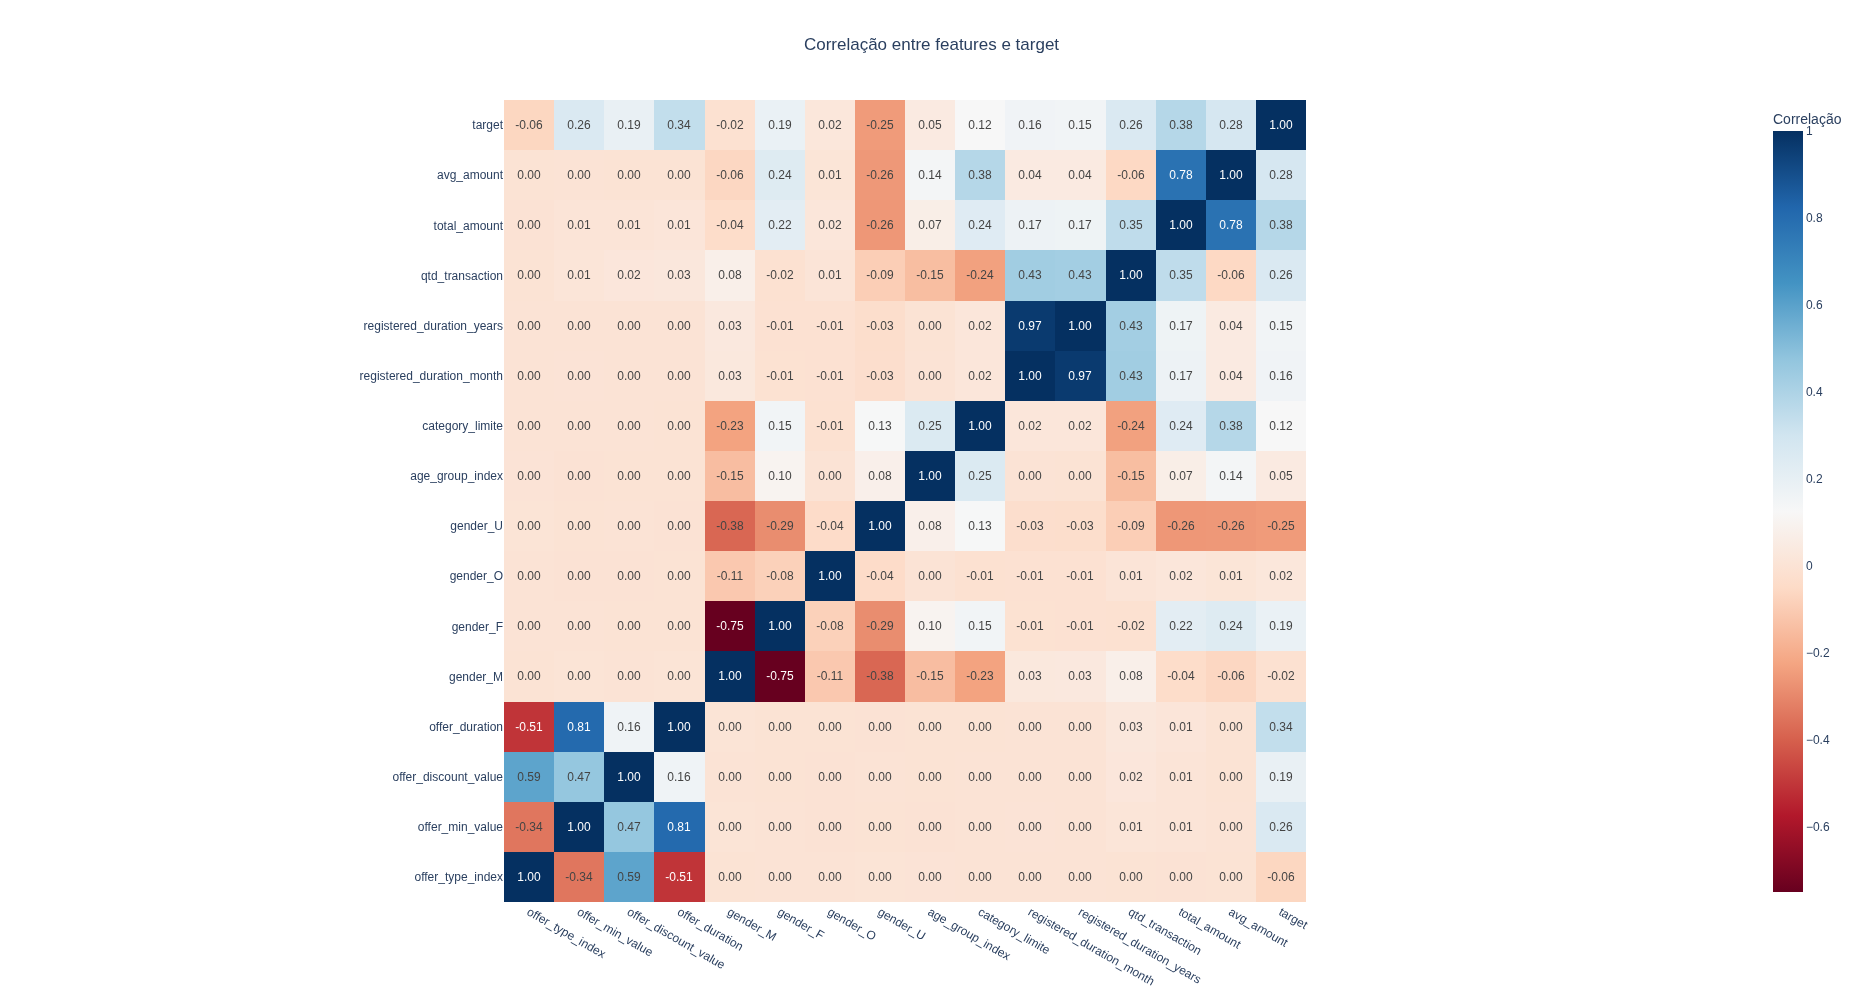

In [318]:
correlation_matrix = df_features[features + ['target']].toPandas().corr()

fig = px.imshow(
    correlation_matrix,
    text_auto=".2f",           
    color_continuous_scale="RdBu",  
    origin="lower",
    title="Correlação entre features e target"
)

fig.update_layout(
    width=1500,
    height=1000,
    title=dict(x=0.5, xanchor="center"), 
    coloraxis_colorbar=dict(title="Correlação")
)

fig.show()

In [211]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_features = assembler.transform(df_features)

train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=42)

In [212]:
df_features.count(), train_df.count()+test_df.count()

(63288, 63288)

In [213]:
rf = RandomForestClassifier(labelCol="target", 
                            featuresCol="features", 
                            # weightCol="classWeightCol",
                            numTrees=200, 
                            maxDepth=10, 
                            maxBins=80
                        )
model = rf.fit(train_df)

25/08/09 19:50:04 WARN DAGScheduler: Broadcasting large task binary with size 1199.9 KiB
25/08/09 19:50:06 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/08/09 19:50:10 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/08/09 19:50:15 WARN DAGScheduler: Broadcasting large task binary with size 1079.6 KiB
25/08/09 19:50:16 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
25/08/09 19:50:23 WARN DAGScheduler: Broadcasting large task binary with size 1873.7 KiB
25/08/09 19:50:24 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
25/08/09 19:50:31 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
                                                                                

In [214]:
pred = model.transform(test_df)

In [215]:
pred = pred.withColumn("prob_vec", vector_to_array(F.col("probability")))\
           .withColumn("y_proba_class0", F.col("prob_vec")[0])\
           .withColumn("y_proba_class1", F.col("prob_vec")[1])

In [216]:
conf_matrix_df = pred.select("target", "prediction")\
                     .crosstab("target", "prediction").fillna(0)
conf_matrix_df.show()

25/08/09 19:50:34 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/08/09 19:50:36 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/08/09 19:50:36 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/08/09 19:50:37 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/08/09 19:50:37 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/08/09 19:50:39 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


+-----------------+----+----+
|target_prediction| 0.0| 1.0|
+-----------------+----+----+
|                0|5976| 982|
|                1| 618|5237|
+-----------------+----+----+



25/08/09 19:50:39 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
                                                                                

##### Podemos melhorar um pouco esses Falsos Negativo encontrando um melhor ponto de corte (Temos que ter atenção, pois mudar isso vai depender do negócio, em outras palavras, da estratégia de negócio)
 - Vale a pena pro negócio enviar mais ofertas que tenham uma baixa probabilidade de aceitação sabendo que vamos capturar mais clientes com alta probabilidade de aceitação?

##### Otimizando Tresh automaticamente

In [217]:
def metrics_at(df, tresh):
    TN = df.where(f"y_proba_class1 < {tresh} AND target=0").count()
    FN = df.where(f"y_proba_class1 < {tresh} AND target=1").count()
    FP = df.where(f"y_proba_class1 >= {tresh} AND target=0").count()
    TP = df.where(f"y_proba_class1 >= {tresh} AND target=1").count()

    precision = TP / (TP + FP) if (TP + FP)>0 else 0.0
    recall = TP / (TP + FN) if (TP + FN)>0 else 0.0
    f1 = (2*precision*recall)/(precision+recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1, TP, FP, TN, FN

def optimize_threshold(df):
    qs = [i/100 for i in range(5, 96)]
    thresholds = df.approxQuantile("y_proba_class1", qs, 0.001)

    best = (None, -1.0) 
    for t in thresholds:
        p,r,f1,TP,FP,TN,FN = metrics_at(df, t)
        if f1 > best[1]:
            best = (t, f1)
    best_t = best[0]

    return best_t

In [147]:
# pred_probs = pred.select('y_proba_class1', 'target')
# tresh = optimize_threshold(pred_probs)

# print(f"Melhor threshold por F1: {tresh:.3f}")

25/08/09 18:36:26 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:36:27 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:36:27 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:36:28 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:36:29 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:36:30 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:36:31 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:36:31 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:36:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:36:33 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:36:34 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:36:34 WARN DAGScheduler: Broadcasting larg

Melhor threshold por F1: 0.368


In [218]:
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred.select('y_proba_class1', 'target'), 0.368)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/09 19:51:09 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/08/09 19:51:10 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/08/09 19:51:11 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/08/09 19:51:13 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
[Stage 15094:>                                                      (0 + 1) / 1]

5635 1323 363 5492
precision: 0.80587
recall: 0.93800
f1: 0.86693


##### Gerando previsao na base toda

In [219]:
df_base = assembler.transform(df_features.drop('features'))

preds_base = model.transform(df_base)

preds_base = preds_base.withColumn("prob_vec", vector_to_array(F.col("probability")))\
                       .withColumn("y_proba_class0", F.col("prob_vec")[0])\
                       .withColumn("y_proba_class1", F.col("prob_vec")[1])

In [220]:
preds_base.show()

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------------+------------------+------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|      total_amount|        avg_amount|target|            features|       rawPrediction|         probability|prediction|            prob_vec|      y_proba_class0|      y_proba_class1|
+-------

25/08/09 19:51:31 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


In [221]:
conf_matrix_df = preds_base.select("target", "prediction")\
                           .crosstab("target", "prediction").fillna(0)
conf_matrix_df.show()

25/08/09 19:51:37 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/08/09 19:51:40 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:51:40 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:51:40 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:51:41 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/08/09 19:51:43 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


+-----------------+-----+-----+
|target_prediction|  0.0|  1.0|
+-----------------+-----+-----+
|                0|29667| 4625|
|                1| 2828|26168|
+-----------------+-----+-----+



25/08/09 19:51:43 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
                                                                                

In [222]:
pred_probs = preds_base.select('y_proba_class1', 'target')
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred_probs, 0.5)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/09 19:51:44 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:51:46 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:51:49 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:51:51 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
[Stage 15156:>                                                      (0 + 1) / 1]

29667 4625 2828 26168
precision: 0.84980
recall: 0.90247
f1: 0.87534


In [223]:
pred_probs = preds_base.select('y_proba_class1', 'target')
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred_probs, 0.368)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/09 19:51:53 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:51:56 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:51:58 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:52:00 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
[Stage 15188:>                                                      (0 + 1) / 1]

28004 6288 1574 27422
precision: 0.81347
recall: 0.94572
f1: 0.87462


In [168]:
# pred_probs = preds_base.select('y_proba_class1', 'target')
# tresh = optimize_threshold(pred_probs)

# print(f"Melhor threshold por F1: {tresh:.3f}")

25/08/09 18:58:31 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:58:33 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:58:36 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:58:38 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:58:41 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:58:43 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:58:45 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:58:47 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:58:50 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:58:52 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:58:54 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 18:58:56 WARN DAGScheduler: Broadcasting larg

Melhor threshold por F1: 0.454


In [224]:
pred_probs = preds_base.select('y_proba_class1', 'target')
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred_probs, 0.454)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/09 19:52:35 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:52:38 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:52:40 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/09 19:52:43 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
[Stage 15220:>                                                      (0 + 1) / 1]

29138 5154 2359 26637
precision: 0.83788
recall: 0.91864
f1: 0.87640


In [225]:
preds_base.count(), df_features.count()

(63288, 63288)

In [226]:
preds_base.show(5)

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------+----------+------+--------------------+--------------------+--------------------+----------+--------------------+-------------------+------------------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|total_amount|avg_amount|target|            features|       rawPrediction|         probability|prediction|            prob_vec|     y_proba_class0|    y_proba_class1|
+--------------------+--------------------

25/08/09 19:52:45 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


In [227]:
preds_base.write.format("parquet").mode("overwrite").save('../data/trusted/rf_output_model')

25/08/09 19:52:55 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
                                                                                

In [144]:
# multi_eval_acc = MulticlassClassificationEvaluator(
#                                             labelCol="target", 
#                                             predictionCol="prediction", 
#                                             metricName="accuracy"
#                                         )
# multi_eval_f1 = MulticlassClassificationEvaluator(
#                                             labelCol="target", 
#                                             predictionCol="prediction", 
#                                             metricName="f1"
#                                         )
# acc = multi_eval_acc.evaluate(pred)
# f1  = multi_eval_f1.evaluate(pred)

# print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}")

In [145]:
# prec_eval = MulticlassClassificationEvaluator(
#                             labelCol="target",
#                             predictionCol="prediction",
#                             metricName="precisionByLabel"
#                         )
                        
# rec_eval = MulticlassClassificationEvaluator(
#                             labelCol="target",
#                             predictionCol="prediction",
#                             metricName="recallByLabel"
#                         )

# metrics = {}
# for label in [0.0, 1.0]:
#     prec_eval.setMetricLabel(label)
#     rec_eval.setMetricLabel(label)
#     metrics[f"precision_{int(label)}"] = prec_eval.evaluate(pred)
#     metrics[f"recall_{int(label)}"] = rec_eval.evaluate(pred)
    
# for m, v in metrics.items():
#     print(f"{m}: {v:.4f}\n")

# KMeans PySpark

In [262]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [319]:
features = ['registered_duration_month', 'registered_duration_years', 'gender_M', 'gender_F', 'gender_O','gender_U', 'age_group_index', 
            'credit_card_limit', 'category_limite', 'qtd_transaction', 'total_amount', 'avg_amount']

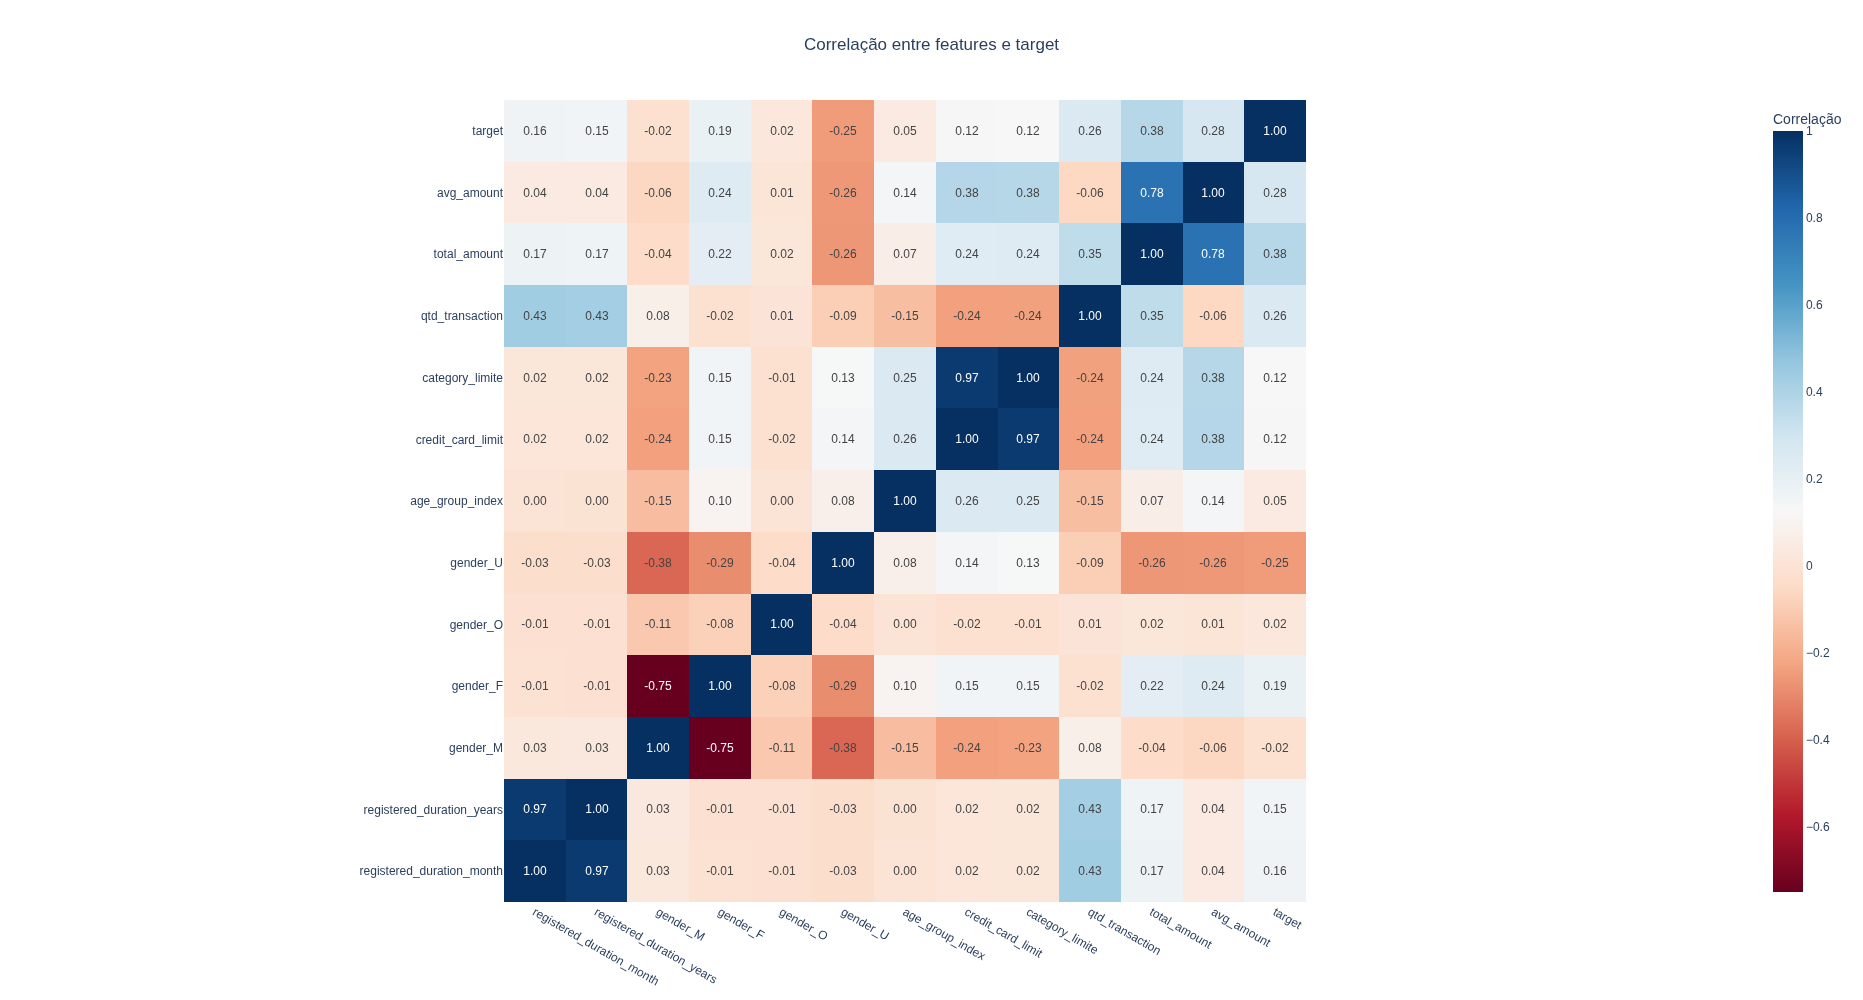

In [320]:
correlation_matrix = df_features[features + ['target']].toPandas().corr()

fig = px.imshow(
    correlation_matrix,
    text_auto=".2f",           
    color_continuous_scale="RdBu",  
    origin="lower",
    title="Correlação entre features e target"
)

fig.update_layout(
    width=1500,
    height=1000,
    title=dict(x=0.5, xanchor="center"), 
    coloraxis_colorbar=dict(title="Correlação")
)

fig.show()

In [258]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_features_kmeans = assembler.transform(df_features)

In [263]:
scaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=True)
df_features_kmeans = scaler.fit(df_features_kmeans).transform(df_features_kmeans)

In [264]:
df_features_kmeans.show(5)

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------+----------+------+--------------------+--------------------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|total_amount|avg_amount|target|            features|     features_scaled|
+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+---------------

In [266]:
kmeans = KMeans(featuresCol="features_scaled", predictionCol="cluster", k=5, seed=42)
model_kmeans = kmeans.fit(df_features_kmeans)

In [304]:
df_clusters = model_kmeans.transform(df_features_kmeans)

In [306]:
df_clusters.write.format("parquet").mode("overwrite").save('../data/trusted/km_output_model')

In [309]:
df_clusters = df_clusters.select("client_id", "cluster").distinct()
df_clusters.show(5)

+--------------------+-------+
|           client_id|cluster|
+--------------------+-------+
|04e39b3e8fc449cfb...|      4|
|0a3e6bcfc66445bab...|      1|
|0d24a49bc2ca4b388...|      2|
|0d74b166a5e54b269...|      1|
|0f457f3ccf254eb0a...|      1|
+--------------------+-------+
only showing top 5 rows


In [310]:
df_features.join(df_clusters, on="client_id", how="inner")\
            .groupBy("cluster").agg(*[F.round(F.avg(c), 2).alias(f"avg_{c}") for c in features])\
            .orderBy("cluster").show()

+-------+-----------------------------+-----------------------------+------------+------------+------------+------------+-------------------+---------------------+-------------------+-------------------+----------------+--------------+
|cluster|avg_registered_duration_month|avg_registered_duration_years|avg_gender_M|avg_gender_F|avg_gender_O|avg_gender_U|avg_age_group_index|avg_credit_card_limit|avg_category_limite|avg_qtd_transaction|avg_total_amount|avg_avg_amount|
+-------+-----------------------------+-----------------------------+------------+------------+------------+------------+-------------------+---------------------+-------------------+-------------------+----------------+--------------+
|      0|                       102.81|                         8.09|         0.3|         0.7|         0.0|         0.0|               4.92|             92852.45|               3.96|               7.31|          217.81|         29.78|
|      1|                       121.23|                 

In [311]:
df_cluster_offers = df_features.select("client_id", "offer_id").distinct()\
                               .join(df_clusters, on="client_id", how="inner")
df_cluster_offers.show(5, truncate=False)

+--------------------------------+--------------------------------+-------+
|client_id                       |offer_id                        |cluster|
+--------------------------------+--------------------------------+-------+
|04e39b3e8fc449cfbcafd7dba2429f1c|4d5c57ea9a6940dd891ad53e9dbe8da0|4      |
|04e39b3e8fc449cfbcafd7dba2429f1c|2298d6c36e964ae4a3e7e9706d1fb8c2|4      |
|04e39b3e8fc449cfbcafd7dba2429f1c|0b1e1539f2cc45b7b9fa7c272da2e1d7|4      |
|0a3e6bcfc66445babbaeee2ce9a9fd85|fafdcd668e3743c1bb461111dcafc2a4|1      |
|0a3e6bcfc66445babbaeee2ce9a9fd85|9b98b8c7a33c4b65b9aebfe6a799e6d9|1      |
+--------------------------------+--------------------------------+-------+
only showing top 5 rows


In [312]:
df_cluster_popular = df_cluster_offers.groupBy("cluster", "offer_id").count()\
                                      .withColumnRenamed("count", "qtd_clientes")
df_cluster_popular.show(5, truncate=False)

+-------+--------------------------------+------------+
|cluster|offer_id                        |qtd_clientes|
+-------+--------------------------------+------------+
|1      |fafdcd668e3743c1bb461111dcafc2a4|1057        |
|0      |2906b810c7d4411798c6938adc9daaa5|1360        |
|3      |fafdcd668e3743c1bb461111dcafc2a4|782         |
|0      |f19421c1d4aa40978ebb69ca19b0e20d|1315        |
|1      |3f207df678b143eea3cee63160fa8bed|971         |
+-------+--------------------------------+------------+
only showing top 5 rows


In [313]:
df_clusters.join(df_cluster_popular, on="cluster", how="inner")\
           .join(df_features.select("client_id", "offer_id").distinct(), on=["client_id", "offer_id"], how="left_anti")\
           .distinct().orderBy('client_id', "cluster", F.desc("qtd_clientes"))\
.show(truncate=False)

+--------------------------------+--------------------------------+-------+------------+
|client_id                       |offer_id                        |cluster|qtd_clientes|
+--------------------------------+--------------------------------+-------+------------+
|0009655768c64bdeb2e877511632db8f|9b98b8c7a33c4b65b9aebfe6a799e6d9|2      |1873        |
|0009655768c64bdeb2e877511632db8f|0b1e1539f2cc45b7b9fa7c272da2e1d7|2      |1871        |
|0009655768c64bdeb2e877511632db8f|4d5c57ea9a6940dd891ad53e9dbe8da0|2      |1868        |
|0009655768c64bdeb2e877511632db8f|2298d6c36e964ae4a3e7e9706d1fb8c2|2      |1844        |
|0009655768c64bdeb2e877511632db8f|ae264e3637204a6fb9bb56bc8210ddfd|2      |1808        |
|00116118485d4dfda04fdbaba9a87b5c|4d5c57ea9a6940dd891ad53e9dbe8da0|3      |813         |
|00116118485d4dfda04fdbaba9a87b5c|2298d6c36e964ae4a3e7e9706d1fb8c2|3      |810         |
|00116118485d4dfda04fdbaba9a87b5c|ae264e3637204a6fb9bb56bc8210ddfd|3      |808         |
|00116118485d4dfda04f

In [314]:
df_merge.filter("client_id='00116118485d4dfda04fdbaba9a87b5c'").select("offer_id", "qtd_offer_viewed", "qtd_offer_completed").show(truncate=False)

+--------------------------------+----------------+-------------------+
|offer_id                        |qtd_offer_viewed|qtd_offer_completed|
+--------------------------------+----------------+-------------------+
|f19421c1d4aa40978ebb69ca19b0e20d|2               |0                  |
+--------------------------------+----------------+-------------------+



In [301]:
df_merge

DataFrame[client_id: string, offer_id: string, time_received: array<double>, qtd_offer_received: bigint, time_viewed: array<double>, qtd_offer_viewed: bigint, time_completed: array<double>, qtd_offer_completed: bigint, sum_reward: double, registered_on: date, registered_duration_days: int, registered_duration_month: bigint, registered_duration_years: bigint, gender: string, gender_M: int, gender_F: int, gender_O: int, gender_U: int, age: int, age_group: string, age_group_index: bigint, credit_card_limit: int, category_limite: int, offer_type: string, offer_min_value: int, offer_discount_value: int, offer_duration: double, channel_mobile: int, channel_email: int, channel_social: int, channel_web: int, offer_type_index: bigint, time_transaction: array<double>, qtd_transaction: bigint, total_amount: double, avg_amount: double]

# Rf Scikit

In [101]:
features = ['offer_type_index',  'offer_min_value', 'offer_discount_value', 'offer_duration', 'gender_M', 
            'gender_F', 'gender_O', 'gender_U', 'age_group_index','category_limite', 'registered_duration_month',
            'registered_duration_years', 'qtd_transaction', 'total_amount', 'avg_amount']

dataset_p = df_features.toPandas()
dataset_p = dataset_p[features + ['target']].drop_duplicates()

X = dataset_p[features]
y = dataset_p['target']

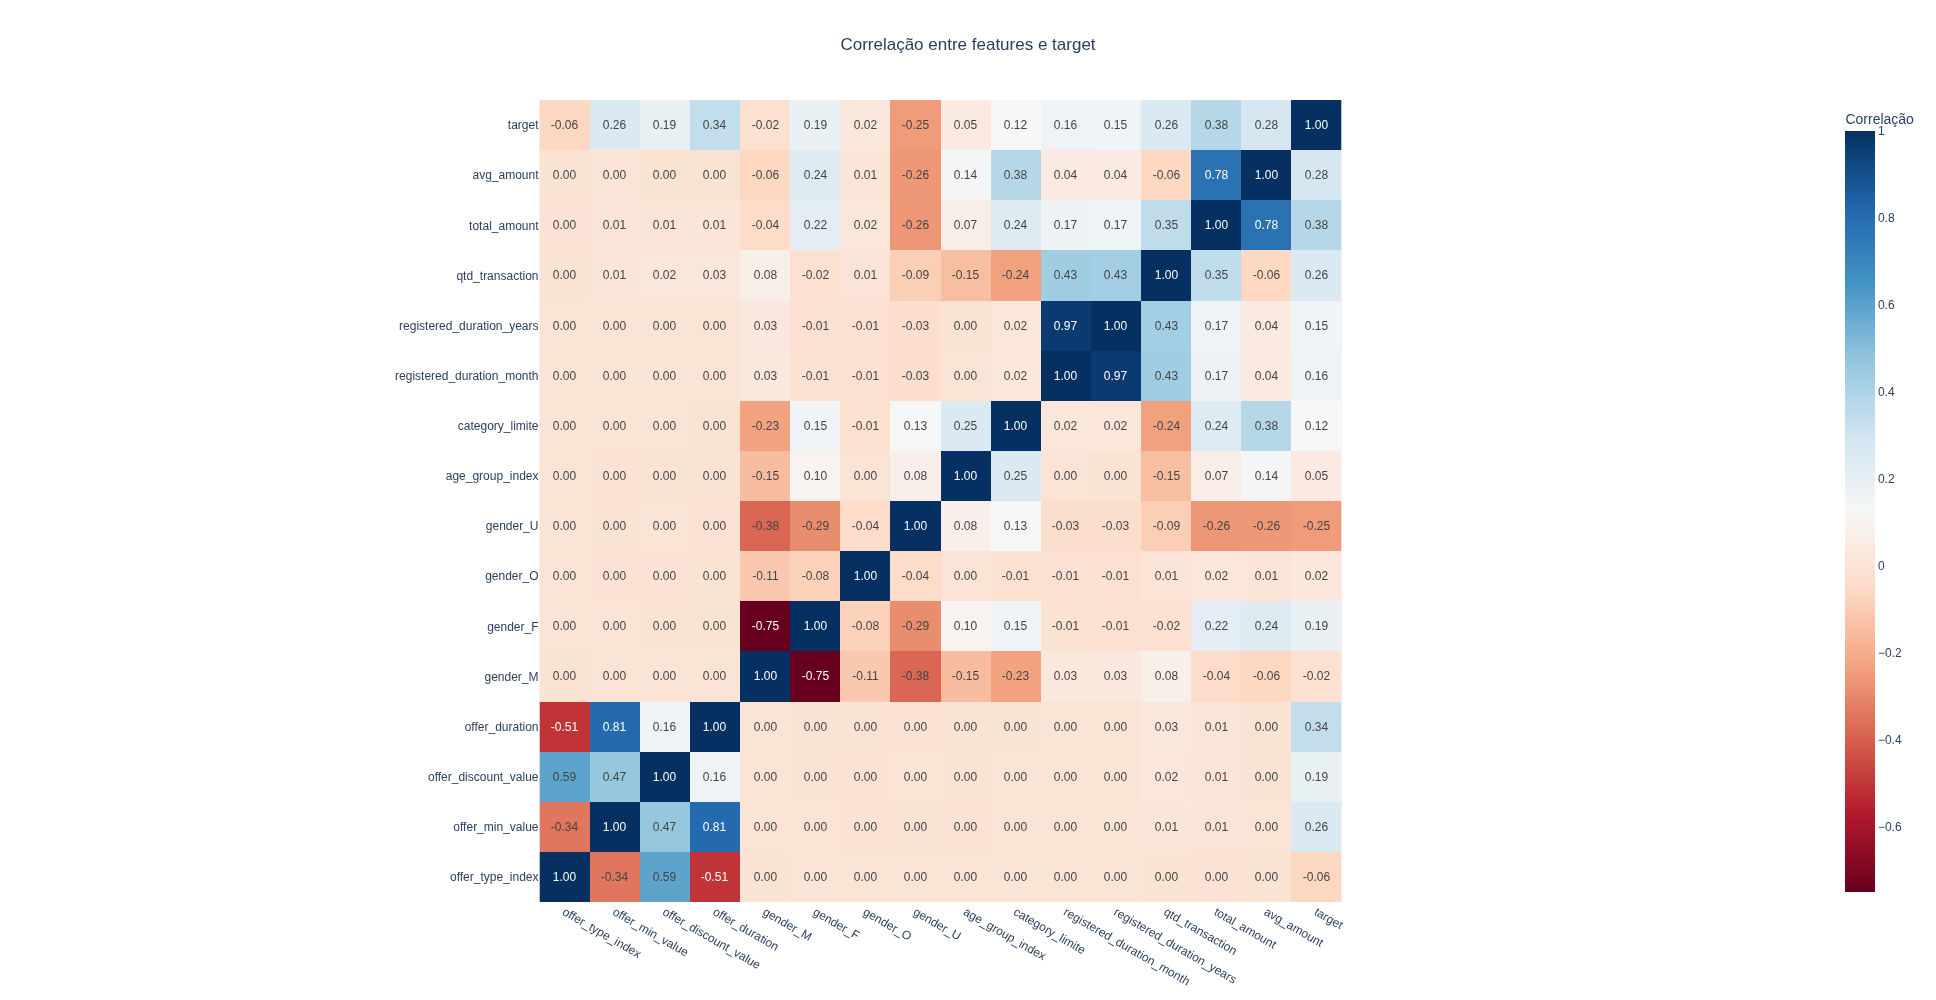

In [118]:
correlation_matrix = dataset_p[features + ['target']].corr()

fig = px.imshow(
    correlation_matrix,
    text_auto=".2f",           
    color_continuous_scale="RdBu",  
    origin="lower",
    title="Correlação entre features e target"
)

fig.update_layout(
    width=1500,
    height=1000,
    title=dict(x=0.5, xanchor="center"), 
    coloraxis_colorbar=dict(title="Correlação")
)

fig.show()

In [129]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, roc_auc_score

In [120]:
classes = [0, 1]
classes_array = np.array(classes)

class_weights = compute_class_weight(class_weight='balanced', classes=classes_array, y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict

{0: np.float64(0.9244890788780231), 1: np.float64(1.0889433025244861)}

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
X_train.shape, X_test.shape

((50520, 15), (12630, 15))

In [123]:
model = RandomForestClassifier(n_estimators=100,  random_state=42)
model.fit(X_train, y_train) 

RandomForestClassifier(random_state=42)

In [124]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [125]:
y_pred

array([1, 0, 0, ..., 0, 0, 0], dtype=int32)

In [126]:
y_pred_proba

array([[0.22, 0.78],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [0.69, 0.31],
       [0.99, 0.01]])

In [127]:
y_pred_proba[:, 1]

array([0.78, 0.  , 0.  , ..., 0.  , 0.31, 0.01])

In [130]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [131]:
print(f"Model Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.86
Precision: 0.84
Recall: 0.88
ROC-AUC Score: 0.87
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      6730
           1       0.84      0.88      0.86      5900

    accuracy                           0.86     12630
   macro avg       0.86      0.87      0.86     12630
weighted avg       0.87      0.86      0.86     12630



In [132]:
df_val = df_features[features].toPandas()
y_pred = model.predict_proba(df_val)

In [133]:
y_pred[:,1]

array([0.98, 0.  , 0.  , ..., 0.98, 0.99, 1.  ])

In [135]:
df_proba = spark.createDataFrame([(float(x),) for x in y_pred[:,1]], ["proba_classe_1"])\
                .withColumn("idx", F.monotonically_increasing_id())
df_proba.show(5, truncate=False)

+--------------+---+
|proba_classe_1|idx|
+--------------+---+
|0.98          |0  |
|0.0           |1  |
|0.0           |2  |
|0.94          |3  |
|1.0           |4  |
+--------------+---+
only showing top 5 rows


In [136]:
df_proba.count(), df_features.count()

(63288, 63288)

In [137]:
# df_supervised = dataset[['client_id'] + features]\
#                     .withColumn("idx", F.monotonically_increasing_id())\
#                     .join(df_proba, on='idx', how='inner')\
#                     .select('client_id', 'offer_type_index', 'proba_classe_1')
df_supervised = df_features\
                    .withColumn("idx", F.monotonically_increasing_id())\
                    .join(df_proba, on='idx', how='inner')\
                    .groupBy('client_id', 'offer_type_index').agg(F.max('proba_classe_1').alias('proba_classe_1'))
                    # .select('client_id', 'offer_type_index', 'proba_classe_1')
df_supervised.show(truncate=False)

+--------------------------------+----------------+--------------+
|client_id                       |offer_type_index|proba_classe_1|
+--------------------------------+----------------+--------------+
|107e20bafe4c43b9ac081307cb37f9ac|1               |0.0           |
|02efe2a67be247a686f79ba1cbce42f1|0               |0.98          |
|08ff7a65c7824da19966319a5cd99bc2|2               |1.0           |
|0020ccbbb6d84e358d3414a3ff76cffd|2               |1.0           |
|05c001b0be8a436dba8f7fdb7ac9273b|0               |0.79          |
|02b7a80a321c4b078af92d494cc0f012|2               |0.99          |
|0a3a378dedac4d5f80aa616e5c8007b3|2               |0.67          |
|11a827d5954740588312dd6246076f78|2               |1.0           |
|120a5a55d3d9498294bfb5b892179f95|1               |0.0           |
|0681388282b14555ac390bef6c526ed7|1               |0.0           |
|0cc6e8553c844c02ab525bc466aa569b|2               |0.83          |
|0a28210b220047fb88b58fe001f940c0|2               |0.99       

In [139]:
df_supervised.join(df_offers.select('offer_type', 'offer_type_index').distinct(), on='offer_type_index', how='inner')\
             .join(df_freq_bayes, on=['client_id', 'offer_type'], how='inner')\
             .withColumn("offer_score", F.col("freq_bayes")*F.col("proba_classe_1"))\
             .withColumn("ranking", F.row_number().over(Window.partitionBy("client_id").orderBy(F.col("offer_score").desc())))\
             .select('client_id', 'offer_id', 'offer_type', 'freq_bayes', 'proba_classe_1', 'offer_score', 'ranking')\
             .orderBy('client_id', 'ranking')\
             .show(25, truncate=False)

+--------------------------------+--------------------------------+-------------+------------------+--------------+-------------------+-------+
|client_id                       |offer_id                        |offer_type   |freq_bayes        |proba_classe_1|offer_score        |ranking|
+--------------------------------+--------------------------------+-------------+------------------+--------------+-------------------+-------+
|0009655768c64bdeb2e877511632db8f|f19421c1d4aa40978ebb69ca19b0e20d|bogo         |1.0               |0.94          |0.94               |1      |
|0009655768c64bdeb2e877511632db8f|2906b810c7d4411798c6938adc9daaa5|discount     |0.5               |1.0           |0.5                |2      |
|0009655768c64bdeb2e877511632db8f|fafdcd668e3743c1bb461111dcafc2a4|discount     |0.5               |1.0           |0.5                |3      |
|0009655768c64bdeb2e877511632db8f|3f207df678b143eea3cee63160fa8bed|informational|0.0               |0.0           |0.0                |4

In [184]:
features = ['age_group_index', 'gender_M', 'gender_F', 'gender_O', 'gender_U', "category_limite", "registered_duration_month"]

Xs = df_features[features].distinct().toPandas()
Xs.head()

,age_group_index,gender_M,gender_F,gender_O,gender_U,category_limite,registered_duration_month
0,4,0,1,0,0,2,91
1,4,0,1,0,0,4,95
2,5,1,0,0,0,1,122
3,5,0,0,0,1,5,101
4,6,0,1,0,0,4,91


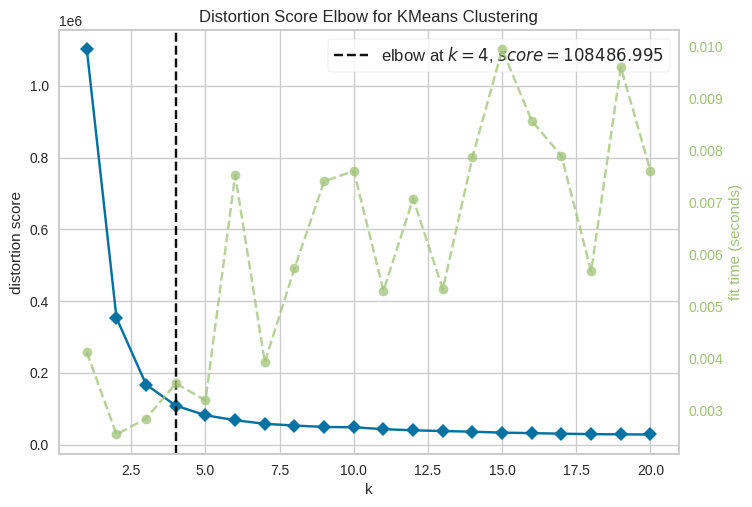

In [185]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,21))
visualizer.fit(Xs)         
visualizer.show();    

In [186]:
model = KMeans(n_clusters=4, random_state=42).fit(Xs)
kmeans_clusters = model.predict(Xs)
kmeans_clusters

array([0, 0, 2, ..., 1, 2, 0], dtype=int32)

In [187]:
Xs['cluster'] = kmeans_clusters
print(f'Silhouette Score: ', silhouette_score(Xs, kmeans_clusters))

Silhouette Score:  0.4850192418973879


In [188]:
Xs

,age_group_index,gender_M,gender_F,gender_O,gender_U,category_limite,registered_duration_month,cluster
0,4,0,1,0,0,2,91,0
1,4,0,1,0,0,4,95,0
2,5,1,0,0,0,1,122,2
3,5,0,0,0,1,5,101,1
4,6,0,1,0,0,4,91,0
...,...,...,...,...,...,...,...,...
4445,8,0,1,0,0,1,107,1
4446,2,1,0,0,0,2,109,1
4447,7,1,0,0,0,2,105,1
4448,5,0,0,0,1,1,120,2


In [189]:
# Agrupar por cluster e calcular as médias e contagem
df_cluster_stats = Xs.groupby("cluster").agg({
                                                "age_group_index": "mean",
                                                "gender_M": "mean",
                                                "gender_F": "mean",
                                                "gender_O": "mean",
                                                "gender_U": "mean",
                                                "category_limite": "mean",
                                                "registered_duration_month": "mean",
                                                "cluster": "count"
                                            }).rename(columns={
                                                "gender_M": "pct_gender_M",
                                                "gender_F": "pct_gender_F",
                                                "gender_O": "pct_gender_O",
                                                "gender_U": "pct_gender_U",
                                                "cluster": "count_clients"
                                            }).reset_index()
df_cluster_stats

,cluster,age_group_index,pct_gender_M,pct_gender_F,pct_gender_O,pct_gender_U,category_limite,registered_duration_month,count_clients
0,0,4.375520,0.303624,0.310160,0.064171,0.322044,2.751634,91.060012,1683
1,1,4.308528,0.332776,0.343645,0.030936,0.292642,2.796823,105.029264,1196
2,2,4.176644,0.398430,0.333660,0.030422,0.237488,2.648675,117.536801,1019
3,3,3.898551,0.612319,0.298913,0.014493,0.074275,2.284420,135.498188,552


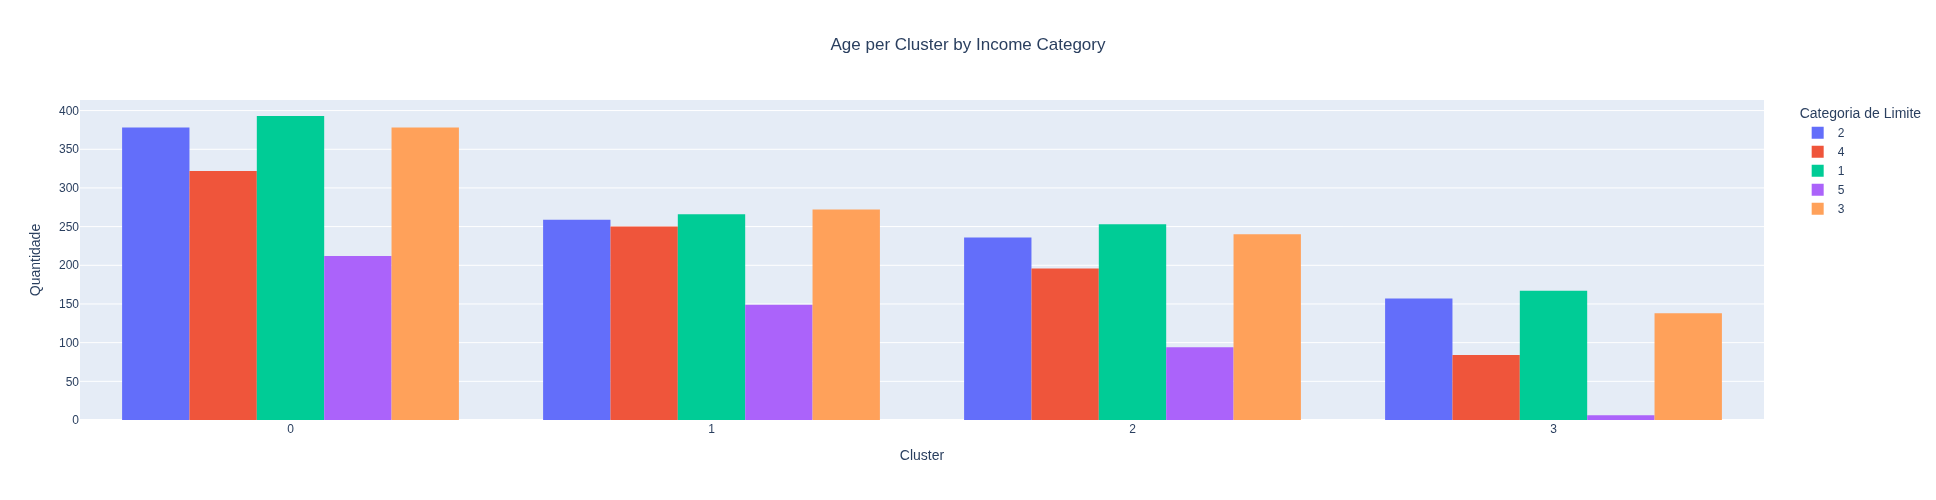

In [190]:
fig = px.histogram(
    Xs.drop_duplicates(),
    x="cluster",
    color="category_limite",    
    barmode="group",           
    title="Age per Cluster by Income Category",
    labels={
        "cluster": "Cluster",
        "count": "Quantidade",
        "category_limite": "Categoria de Limite"
    }
)

fig.update_layout(
    width=1200,
    height=500,
    title=dict(x=0.5, xanchor="center"),
    xaxis_title="Cluster",
    yaxis_title="Quantidade"
)

fig.show()


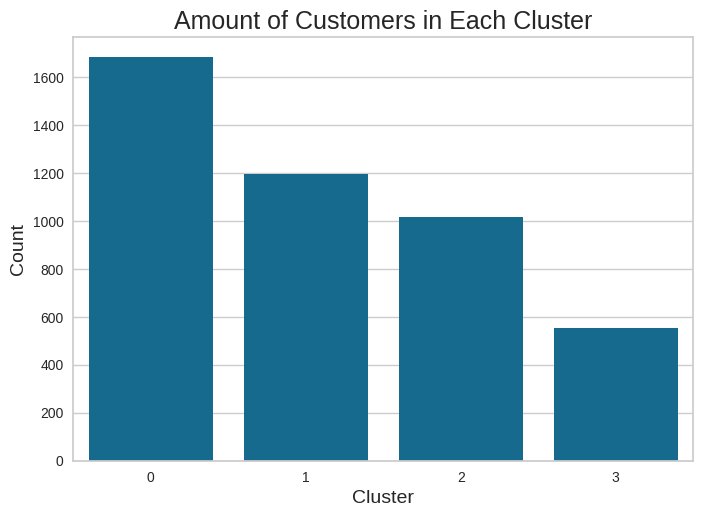

In [191]:
sns.countplot(x=Xs['cluster'])
plt.title('Amount of Customers in Each Cluster', size = 18)
plt.xlabel('Cluster', size = 14)
plt.ylabel('Count', size = 14);

Text(0, 0.5, 'Count')

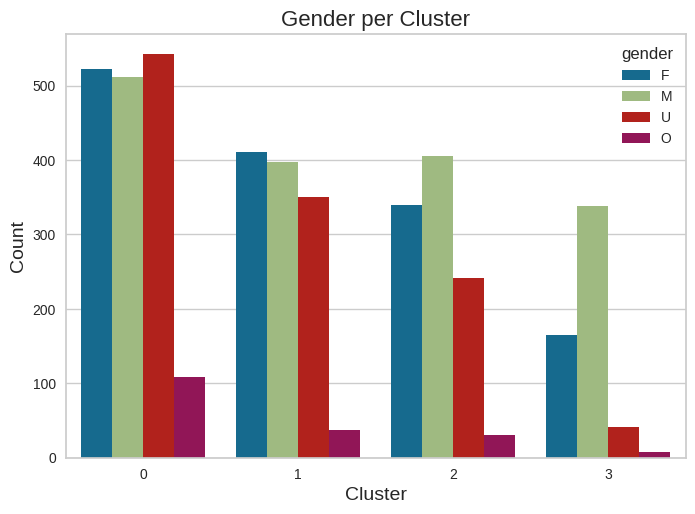

In [192]:
import numpy as np

conditions = [
    Xs['gender_M'] == 1,
    Xs['gender_F'] == 1,
    Xs['gender_O'] == 1,
    Xs['gender_U'] == 1
]
choices = ['M', 'F', 'O', 'U']
Xs['gender'] = np.select(conditions, choices, default=None)

sns.countplot(data=Xs, hue='gender', x='cluster')
plt.title('Gender per Cluster', size = 16)
plt.xlabel('Cluster', size = 14)
plt.ylabel('Count', size = 14)

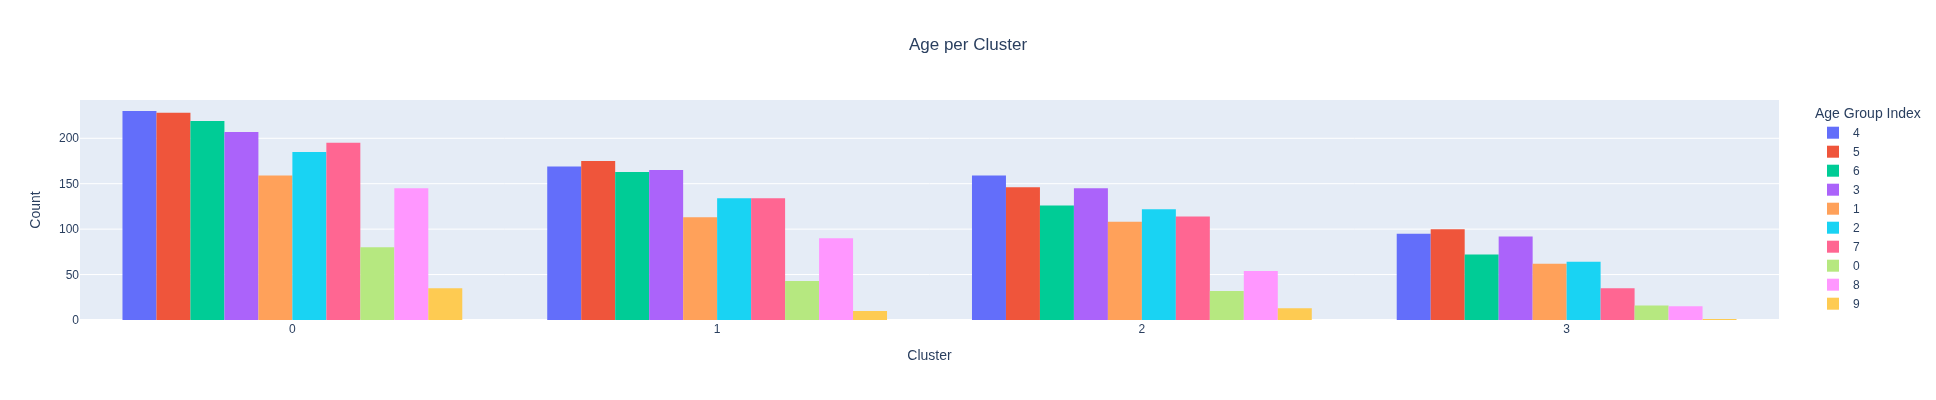

In [193]:
fig = px.histogram(
    Xs,
    x="cluster",                
    color="age_group_index",   
    barmode="group", 
    title="Age per Cluster",
    labels={"cluster": "Cluster", "count": "Count", "age_group_index": "Age Group Index"}
)

# Ajustes de layout
fig.update_layout(
    width=1500,
    height=400,
    title=dict(x=0.5, xanchor="center"), 
    xaxis_title="Cluster",
    yaxis_title="Count"
)

fig.show()